# Introduction to Data Science – Lecture 12 – APIs
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecture we will explore how we can extract data from web-APIs. The first part of this tutorial is based on [this blog](https://www.dataquest.io/blog/python-api-tutorial/).

API stands for Application Programming Interface. It is supposed to be a **well defined interface** for consuming data (in contrast to web-scraping), or, more generally, for the **interaction with a remote program** on a server. APIs aren't only generated so that you can read data; they're often designed so that you could write custom software to interact with the API. You could, for example, write your own twitter client! 

APIs are usually well documented, as the organization that provides APIs wants you to use them. 

Here are a couple of examples of sites that have documented APIs:

 * [StackExchange](https://api.stackexchange.com/docs)  
 * [Twitter](https://dev.twitter.com/rest/public)
 * [Facebook](https://developers.facebook.com/docs/graph-api)
 * [KEGG](http://www.genome.jp/kegg/rest/keggapi.html) 
 * [Google Maps](https://developers.google.com/maps/) 
 * and many many more. 
 
Most APIs require some form of authentication and have rules on what you're allowed to do and what not. Follow those rules, or you will be blocked faster than you can say `GET`. 
 
An API works a lot like working with a website, but instead of a human in front of the screen, it's computers talking to each other. 

We'll be using the dominant form of APIs on the web: REST (REpresentational State Transfer). REST APIs use an [URI](https://en.wikipedia.org/wiki/Uniform_Resource_Identifier) (a Uniform Resource Identifier; URLs are one specific form of URIs) to specify what you want to do with and API.

All API methods in REST are relative to a base URL. E.g., for twitter this would be
```
https://api.twitter.com/1.1/
```

A query would look like this: 

```
https://api.twitter.com/1.1/search/tweets.json?q=%40twitterapi
```

REST APIs can return data in different forms, the most common ones are JSON and XML, and of those two, JSON is now dominant. 

JSON stands for JavaScript Object Notation, and is a pretty convenient format, as we'll see. 
 

Let's start with a very simple example, retrieving the current position of the ISS. We will be using the [requests library](http://www.python-requests.org/en/latest/), which will handle our communication with the server.

In [1]:
import requests 
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("http://api.open-notify.org/iss-now.json")

response

<Response [200]>

That looks good, we've received a response and it has status 200. What does the 200 mean? It's a status code - you've probably seen the "Error 404" on the internet. 

Here are a couple of codes:

 * **200** – everything went okay, and the result has been returned (if any)
 * **301** – the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
 * **401** – the server thinks you’re not authenticated. This happens when you don’t send the right credentials to access an API (we’ll talk about authentication later).
 * **400** – the server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
 * **403** – the resource you’re trying to access is forbidden – you don’t have the right permissions to see it.
 * **404** – the resource you tried to access wasn’t found on the server.

Let's try to get a response with a wrong URL:

In [2]:
response_failed = requests.get("http://api.open-notify.org/iss")

response_failed

<Response [400]>

We used the get methods to put in a GET request. There are four different types of requests: 

![Request types](requests.png)
[Source](https://en.wikipedia.org/wiki/Representational_state_transfer)

Let's look at the payload of our previous, successful response:

In [3]:
response.content

b'{"iss_position": {"longitude": "-6.5894", "latitude": "-8.3423"}, "timestamp": 1550174016, "message": "success"}'

We can already see that this is JSON (though it is stored a `bytes` object), but we can check formally:

In [4]:
response.headers['content-type']

'application/json'

We can decode this byte object, then the JSON will be readable. 

In [5]:
response_j = response.content.decode("utf-8")
print(response_j)

{"iss_position": {"longitude": "-6.5894", "latitude": "-8.3423"}, "timestamp": 1550174016, "message": "success"}


Let's take a look at the JSON here:

```JSON
{
  "iss_position": {
    "latitude": -30.005751854107206, 
    "longitude": -104.20085371352678
  }, 
  "message": "success", 
  "timestamp": 1475240215
}
```

This looks a lot like a dictionary! We have key-value pairs. 

We can use the [json library](https://docs.python.org/3/library/json.html) to convert JSON into objects:

In [6]:
import json
response_d = json.loads(response_j)
print(type(response_d))
print(response_d)
response_d["iss_position"]

<class 'dict'>
{'iss_position': {'longitude': '-6.5894', 'latitude': '-8.3423'}, 'timestamp': 1550174016, 'message': 'success'}


{'longitude': '-6.5894', 'latitude': '-8.3423'}

Or, not surprisingly, pandas can also load a json object:

In [7]:
import pandas as pd 

df = pd.read_json(response_j)
df

,iss_position,timestamp,message
latitude,-8.3423,2019-02-14 19:53:36,success
longitude,-6.5894,2019-02-14 19:53:36,success


This isn't quite what we want - we probably want one row per timestamp and longitude and latitude as columns:

In [8]:
def flatten(response_d):
    response_d["latitude"] = response_d["iss_position"]["latitude"]
    response_d["longitude"] = response_d["iss_position"]["longitude"]
    del(response_d["iss_position"])
    return response_d
flatten(response_d)

{'timestamp': 1550174016,
 'message': 'success',
 'latitude': '-8.3423',
 'longitude': '-6.5894'}

That looks better. Let's get a couple of positions of the ISS over time and save it as an array:

In [9]:
import time

def pull_position():
    """Retreives the position of the ISS and returns it as a flat dictionary"""
    response = requests.get("http://api.open-notify.org/iss-now.json")
    response_j = response.content.decode("utf-8")
    response_d = json.loads(response_j)
    flat_response = flatten(response_d)
    return flat_response    

iss_position = []
    
# calls pull_position 10 times with 3 seconds break
for i in range(10):
    flat_response = pull_position()
    iss_position.append(flat_response)
    print(flat_response)
    time.sleep(3)
    
len(iss_position)

{'timestamp': 1550174017, 'message': 'success', 'latitude': '-8.3928', 'longitude': '-6.5525'}
{'timestamp': 1550174020, 'message': 'success', 'latitude': '-8.5441', 'longitude': '-6.4418'}
{'timestamp': 1550174023, 'message': 'success', 'latitude': '-8.7207', 'longitude': '-6.3125'}
{'timestamp': 1550174026, 'message': 'success', 'latitude': '-8.8720', 'longitude': '-6.2016'}
{'timestamp': 1550174029, 'message': 'success', 'latitude': '-9.0233', 'longitude': '-6.0906'}
{'timestamp': 1550174032, 'message': 'success', 'latitude': '-9.1745', 'longitude': '-5.9795'}
{'timestamp': 1550174035, 'message': 'success', 'latitude': '-9.3257', 'longitude': '-5.8682'}
{'timestamp': 1550174039, 'message': 'success', 'latitude': '-9.5020', 'longitude': '-5.7383'}
{'timestamp': 1550174042, 'message': 'success', 'latitude': '-9.6531', 'longitude': '-5.6269'}
{'timestamp': 1550174045, 'message': 'success', 'latitude': '-9.8041', 'longitude': '-5.5153'}


10

Now we can convert this into a nice dataframe:

In [10]:
iss_position_df = pd.DataFrame(iss_position)
iss_position_df['timestamp']  = pd.to_datetime(iss_position_df['timestamp'], unit="s")

iss_position_df = iss_position_df.set_index(pd.DatetimeIndex(iss_position_df['timestamp']))
iss_position_df["latitude"] = iss_position_df["latitude"].map(float)
iss_position_df["longitude"] = iss_position_df["longitude"].map(float)
iss_position_df

,latitude,longitude,message,timestamp
timestamp,,,,
2019-02-14 19:53:37,-8.3928,-6.5525,success,2019-02-14 19:53:37
2019-02-14 19:53:40,-8.5441,-6.4418,success,2019-02-14 19:53:40
2019-02-14 19:53:43,-8.7207,-6.3125,success,2019-02-14 19:53:43
2019-02-14 19:53:46,-8.8720,-6.2016,success,2019-02-14 19:53:46
2019-02-14 19:53:49,-9.0233,-6.0906,success,2019-02-14 19:53:49
2019-02-14 19:53:52,-9.1745,-5.9795,success,2019-02-14 19:53:52
2019-02-14 19:53:55,-9.3257,-5.8682,success,2019-02-14 19:53:55
2019-02-14 19:53:59,-9.5020,-5.7383,success,2019-02-14 19:53:59
2019-02-14 19:54:02,-9.6531,-5.6269,success,2019-02-14 19:54:02


Let's see how the ISS moves

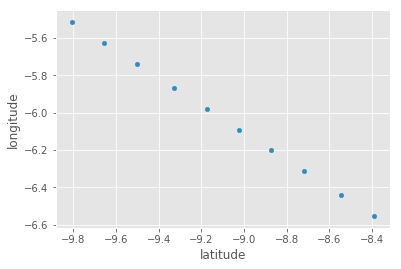

In [11]:
import matplotlib.pyplot as plt
# This next line tells jupyter to render the images inline
%matplotlib inline
plt.style.use('ggplot')
iss_position_df.plot(kind="scatter", x="latitude", y="longitude")

### Querying with Parameters

Requests can be parametrized. You can search for tweets of a specific user, for example, or [retrieve the time the ISS is over SLC](http://open-notify.org/Open-Notify-API/ISS-Pass-Times/)!

The way to query with a get request for the ISS is this:

`http://api.open-notify.org/iss-pass.json?lat=40.758701&lon=-111.876183`

We, of course, could generate that URL ourselves, but the requests library is helpful here. Since JSON is similar to dictionaries, the requests library takes dictionaries for parameters.

In [12]:
url = "http://api.open-notify.org/iss-pass.json"
coordinates = {"lat": 40.758701, "lon": -111.876183, "n":5}

r = requests.get(url, params=coordinates)
data = r.json()
data

{'message': 'success',
 'request': {'altitude': 100,
  'datetime': 1550173012,
  'latitude': 40.758701,
  'longitude': -111.876183,
  'passes': 5},
 'response': [{'duration': 555, 'risetime': 1550177849},
  {'duration': 625, 'risetime': 1550183653},
  {'duration': 621, 'risetime': 1550189446},
  {'duration': 207, 'risetime': 1550195394},
  {'duration': 489, 'risetime': 1550243754}]}

In [13]:
timestamp = data["response"][0]["risetime"]
pd.to_datetime(timestamp,  unit="s")

Timestamp('2019-02-14 20:57:29')

So, the ISS will be above SLC tonight!

### Exercise: How many Astronauts? 

Use the [Open Notify API](http://open-notify.org/Open-Notify-API/People-In-Space/) to find out how many people are in space right now.

## Libraries and Authentication

While we now have the skills to directly talk to an API, it's sometimes a little tedious. Popular APIs often have existing Python libraries that wrap around them. [Here](https://github.com/realpython/list-of-python-api-wrappers) is a long list of wrappers! 

Now we'll explore the Twitter API using the [twython library](https://github.com/ryanmcgrath/twython). Check out the [documentation](https://twython.readthedocs.io/en/latest/).

Unfortunately, most professional APIs will require you to authenticate and will limit you in what you can do – mostly they limit how much data you can retreive at a certain time. To run the following code, you'll have to put in your own credentials (sorry – I can't share mine). 

Install twython:
`pip install twython`

* Go to https://apps.twitter.com/ and create a new app
* Save your consumer key and consumer secret in a file `credentials.py` in the format:
```python
CONSUMER_KEY = "KEY"
CONSUMER_SECRET = "KEY"
```

But before we get started, let's check out what [a tweet looks like](https://dev.twitter.com/overview/api/tweets):

```JSON
{'contributors': None,
  'coordinates': None,
  'created_at': 'Fri Sep 30 18:37:48 +0000 2016',
  'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
  'favorite_count': 2960,
  'favorited': False,
  'geo': None,
  'id': 781926033159249920,
  'id_str': '781926033159249920',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'en',
  'place': None,
  'retweet_count': 1283,
  'retweeted': False,
  'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
  'text': "For those few people knocking me for tweeting at three o'clock in the morning, at least you know I will be there, awake, to answer the call!",
  'truncated': False,
  'user': {'contributors_enabled': False,
   'created_at': 'Wed Mar 18 13:46:38 +0000 2009',
   'default_profile': False,
   'default_profile_image': False,
   'description': '',
   'entities': {'description': {'urls': []},
    'url': {'urls': [{'display_url': 'DonaldJTrump.com',
       'expanded_url': 'http://www.DonaldJTrump.com',
       'indices': [0, 23],
       'url': 'https://t.co/mZB2hymxC9'}]}},
   'favourites_count': 39,
   'follow_request_sent': None,
   'followers_count': 11929387,
   'following': None,
   'friends_count': 41,
   'geo_enabled': True,
   'has_extended_profile': False,
   'id': 25073877,
   'id_str': '25073877',
   'is_translation_enabled': True,
   'is_translator': False,
   'lang': 'en',
   'listed_count': 39225,
   'location': 'New York, NY',
   'name': 'Donald J. Trump',
   'notifications': None,
   'profile_background_color': '6D5C18',
   'profile_background_image_url': 'http://pbs.twimg.com/profile_background_images/530021613/trump_scotland__43_of_70_cc.jpg',
   'profile_background_image_url_https': 'https://pbs.twimg.com/profile_background_images/530021613/trump_scotland__43_of_70_cc.jpg',
   'profile_background_tile': True,
   'profile_banner_url': 'https://pbs.twimg.com/profile_banners/25073877/1468988952',
   'profile_image_url': 'http://pbs.twimg.com/profile_images/1980294624/DJT_Headshot_V2_normal.jpg',
   'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1980294624/DJT_Headshot_V2_normal.jpg',
   'profile_link_color': '0D5B73',
   'profile_sidebar_border_color': 'BDDCAD',
   'profile_sidebar_fill_color': 'C5CEC0',
   'profile_text_color': '333333',
   'profile_use_background_image': True,
   'protected': False,
   'screen_name': 'realDonaldTrump',
   'statuses_count': 33344,
   'time_zone': 'Eastern Time (US & Canada)',
   'url': 'https://t.co/mZB2hymxC9',
   'utc_offset': -14400,
   'verified': True}
```


In [14]:
from twython import Twython
# credentials is a local file with your own credentials. It defines CONSUMER_KEY and CONSUMER_SECRET
# you will have to load your own credentials here.
from credentials_alex import * 
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET)

Here, we have created the Twython library object and authenticated against our user.

Now let's search for a hashtag:

In [15]:
tag = "#resist"
result = twitter.search(q=tag, tweet_mode="extended")
result

{'statuses': [{'created_at': 'Thu Feb 14 19:53:49 +0000 2019',
   'id': 1096135444637597697,
   'id_str': '1096135444637597697',
   'full_text': 'RT @Top_Sergeant: Lock this bitch up too. Lock all the #FatNixons family up.  #TrumpPutinAlliance #TrumpRussia #RussianCollaborators #Trump…',
   'truncated': False,
   'display_text_range': [0, 140],
   'entities': {'hashtags': [{'text': 'FatNixons', 'indices': [55, 65]},
     {'text': 'TrumpPutinAlliance', 'indices': [78, 97]},
     {'text': 'TrumpRussia', 'indices': [98, 110]},
     {'text': 'RussianCollaborators', 'indices': [111, 132]}],
    'symbols': [],
    'user_mentions': [{'screen_name': 'Top_Sergeant',
      'name': '1st Sergeant (First Shirt)',
      'id': 1363545236,
      'id_str': '1363545236',
      'indices': [3, 16]}],
    'urls': []},
   'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
   'source': '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
   'in_reply_to_status_id': None,
   'i

The result is an array of tweets, we can look at specific text:

In [16]:
result["statuses"][0]["full_text"]

'RT @Top_Sergeant: Lock this bitch up too. Lock all the #FatNixons family up.  #TrumpPutinAlliance #TrumpRussia #RussianCollaborators #Trump…'

Or print all the tweets:

In [17]:
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

RT @Top_Sergeant: Lock this bitch up too. Lock all the #FatNixons family up.  #TrumpPutinAlliance #TrumpRussia #RussianCollaborators #Trump…
----
#TheResistance @womensmarch #Resist #NotMyPresident @CoryBooker @SenKamalaHarris  @SpeakerPelosi @nytimes @washingtonpost @OutnumberedFNC @foxandfriends @CNN @MSNBC @donlemon @AprilDRyan @amjoyshow @maddow @rolandsmartin @AmericaNewsroom @SandraSmithFox @kilmeade https://t.co/OWpapDgi6t
----
Time for @SteveSchmidtSES to attack more democrats.
#Resist https://t.co/yseIt0Tleg
----
RT @StarLilyResists: Neither is delusion.  None of this is normal.

#Resist https://t.co/cNNyOuUCI3
----
RT @pollsofpolitics: Are the #Democrats right when saying "@POTUS @realDonaldTrump has no choice but to sign the new  #BorderSecurity bill…
----
Cinematographers Guild Joins Protest Over Move To Trim Oscar Telecast - https://t.co/KEtHeLyv06  #Resist
----
RT @factprobe: Let's connect #Resisters to make us STRONG
keep it positive and change things for the better
#Fol

We can also search for tweets based on usernames:

In [18]:
result = twitter.search(q="@realDonaldTrump",  tweet_mode="extended")
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

@DavidWohl @realDonaldTrump @FBI It's also time for our Coup Compliant media to do it's job and question Barrack Obama about all of this. Exactly what took place in the 1/5/17 oval office meeting? What does "By the Book" mean? Was the Coup done By the Book?
----
@wyoflyboy @GovMikeHuckabee @realDonaldTrump Right? https://t.co/LhZVoUPwEa
----
RT @intheMatrixxx: So far: Brilliant Anons found bank, spa, cars that haven't moved, and 17 min difference on clock.
@realDonaldTrump #QAno…
----
RT @eugenegu: @realDonaldTrump @WhiteHouse All of this is to empower himself politically so that he can escape his crimes like a strongman…
----
RT @mikenorman: Love how unelected, unethical people at the #DOJ just get to decide on their own whether or not to remove a president. #McC…
----
@realDonaldTrump You're not refusing to pay carpenters now, Trump. These people could really use this train service.

The world does not revolve  around you and your uninformed decisions.
----
@GeraldoRivera @realDonald

This returns all tweets that are mentioning a username. We can also explicitly get the tweets of a person. Let's download The Donald's last 50 tweets. [Here](https://dev.twitter.com/rest/reference/get/statuses/user_timeline) is the relevant API documentation, [here](https://github.com/ryanmcgrath/twython/blob/master/twython/endpoints.py) are the definitions for twython.

In [19]:
#twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# count is limited to the last 3200 tweets of a user, a max of 200 per request
trump_result = twitter.get_user_timeline(screen_name="realDonaldTrump", count=50)
trump_result

[{'created_at': 'Thu Feb 14 17:30:39 +0000 2019',
  'id': 1096099414916169730,
  'id_str': '1096099414916169730',
  'text': 'One year ago today, a horrific act of violence took the lives of 14 students and 3 educators in Parkland, Florida.… https://t.co/I4fYuapHlH',
  'truncated': True,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [{'url': 'https://t.co/I4fYuapHlH',
     'expanded_url': 'https://twitter.com/i/web/status/1096099414916169730',
     'display_url': 'twitter.com/i/web/status/1…',
     'indices': [116, 139]}]},
  'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 25073877,
   'id_str': '25073877',
   'name': 'Donald J. Trump',
   'screen_name': 'realDonaldTrump',
   'location': 'Washington, DC',
   'descript

Let's count the numbers for The Donald's favorites and retweets.

In [20]:
trump_favorites = []
trump_retweets = []
trump_texts = []
for status in trump_result:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    trump_favorites.append(status["favorite_count"])
    trump_retweets.append(status["retweet_count"])
    trump_texts.append(status["text"])

One year ago today, a horrific act of violence took the lives of 14 students and 3 educators in Parkland, Florida.… https://t.co/I4fYuapHlH
27079
----
Reviewing the funding bill with my team at the @WhiteHouse!
38468
----
....Many of the top FBI brass were fired, forced to leave, or left. McCabe’s wife received BIG DOLLARS from Clinton… https://t.co/4InFRTx4IC
81886
----
Disgraced FBI Acting Director Andrew McCabe pretends to be a “poor little Angel” when in fact he was a big part of… https://t.co/dfMDqNitPS
76167
----
California has been forced to cancel the massive bullet train project after having spent and wasted many billions o… https://t.co/zQ6MPgxXv5
175234
----
RT @SenTedCruz: Report: Texas crude oil production breaks 1970s record https://t.co/RHpaMLX7G2 via @houstonchron
0
----
https://t.co/BS162NF8HC
66561
----
https://t.co/ruL7Ctpdak
63506
----
RT @WhiteHouse: "Every American in every community and from every walk of life has a right to live in security and to live in peace.

Now let's do the same for Alexandria Ocasio-Cortez.

In [21]:
aoc_results = twitter.get_user_timeline(screen_name="AOC", count=50)
aoc_results

[{'created_at': 'Thu Feb 14 19:37:18 +0000 2019',
  'id': 1096131286903734275,
  'id_str': '1096131286903734275',
  'text': 'RT @JimmyVanBramer: Defeating an anti-union corporation that mistreats workers and assists ICE in terrorizing immigrant communities is a vi…',
  'truncated': False,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [{'screen_name': 'JimmyVanBramer',
     'name': 'Jimmy Van Bramer',
     'id': 28345779,
     'id_str': '28345779',
     'indices': [3, 18]}],
   'urls': []},
  'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 138203134,
   'id_str': '138203134',
   'name': 'Alexandria Ocasio-Cortez',
   'screen_name': 'AOC',
   'location': 'Bronx + Queens, NYC',
   'description': 'Congresswoman for NY-14 (Bronx + Queen

In [22]:
aoc_favorites = []
aoc_retweets = []
aoc_texts = []
for status in aoc_results:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    aoc_favorites.append(status["favorite_count"])
    aoc_retweets.append(status["retweet_count"])
    aoc_texts.append(status["text"])

RT @JimmyVanBramer: Defeating an anti-union corporation that mistreats workers and assists ICE in terrorizing immigrant communities is a vi…
0
----
RT @nkolakowski: The HQ2 "search" was always a thinly disguised attempt to extract maximum tax concessions for opening a satellite office.…
0
----
RT @akarl_smith: .@AOC responding to criticism that by Amazon pulling out of HQ2 in Queens, 25,000 jobs were lost: "We were subsidizing tho…
0
----
Anything is possible: today was the day a group of dedicated, everyday New Yorkers &amp; their neighbors defeated Amazo… https://t.co/EGic6XVJ26
17974
----
Let’s go:

‘We’re starting a 15-city tour + a 50-State campaign, starting in early primary states, to build politic… https://t.co/37cD4Awaa3
21046
----
I often reflect on @AyannaPressley‘s words: “people closest to the pain should be closest to the power.”

@IlhanMN… https://t.co/xhSAcXPtRW
54109
----
RT @natsfert: In cannabis banking hearing, @AOC asks: "are we compounding the racial wealth gap ri

And let's create DataFrames for both of them and explore their stats:

In [23]:
trump_stats = pd.DataFrame({
        "Trump Fav":trump_favorites,
        "Trump RT":trump_retweets,
        "Trum Text":trump_texts
    })

aoc_stats = pd.DataFrame({
      "AOC Fav":aoc_favorites,
      "AOC RT":aoc_retweets, 
      "AOC Text":aoc_texts
        })

In [24]:
trump_stats.head()

,Trump Fav,Trump RT,Trum Text
0,27079,6721,"One year ago today, a horrific act of violence..."
1,38468,7437,Reviewing the funding bill with my team at the...
2,81886,22322,"....Many of the top FBI brass were fired, forc..."
3,76167,21758,Disgraced FBI Acting Director Andrew McCabe pr...
4,175234,44665,California has been forced to cancel the massi...


In [25]:
trump_stats.describe()

,Trump Fav,Trump RT
count,50.000000,50.000000
mean,84039.480000,23100.580000
std,58699.076585,8604.893864
min,0.000000,6721.000000
25%,29926.250000,18096.750000
50%,91720.500000,22835.000000
75%,123360.750000,29076.000000
max,195203.000000,44665.000000


In [26]:
aoc_stats.describe()

,AOC Fav,AOC RT
count,50.000000,50.000000
mean,26580.060000,6350.940000
std,32777.114001,8282.842094
min,0.000000,39.000000
25%,0.000000,1021.500000
50%,17153.500000,3374.000000
75%,42268.500000,7810.750000
max,113031.000000,42976.000000


Now we're plotting the tweets; but we have to sort them first so that they make sense. 

In [27]:
trump_stats = trump_stats.sort_values("Trump Fav")
trump_stats = trump_stats.reset_index(drop=True)
trump_stats.head(30)

,Trump Fav,Trump RT,Trum Text
0,0,20197,RT @DonaldJTrumpJr: Beto trying to counter-pro...
1,0,6905,RT @club4growth: Agreed! Senate needs to confi...
2,0,7694,RT @club4growth: WE AGREE! The time is now! 👉 ...
3,0,28568,"RT @realDonaldTrump: Working hard, thank you! ..."
4,0,22257,RT @DanScavino: 🚨Happening Now: @realDonaldTru...
5,0,11378,RT @SenTedCruz: Report: Texas crude oil produc...
6,0,19859,RT @IngrahamAngle: It was 45 degrees outside a...
7,0,12369,RT @planetepics: They are soooo beautiful and ...
8,0,15296,"RT @WhiteHouse: ""Every American in every commu..."
9,0,14442,RT @WhiteHouse: Americans pay 180 percent of w...


In [28]:
trump_stats.tail(10)

,Trump Fav,Trump RT,Trum Text
40,135198,33364,"We are fighting for all Americans, from all ba..."
41,140077,28590,"....The fact is, when I took over as President..."
42,144341,34084,The Senate Intelligence Committee: THERE IS NO...
43,148977,32025,The Democrats are so self righteous and ANGRY!...
44,149584,29238,I want to thank all Republicans for the work y...
45,167840,33515,"Well, it happened again. Amy Klobuchar announc..."
46,175234,44665,California has been forced to cancel the massi...
47,176314,41360,I think it is very important for the Democrats...
48,188700,33007,No president ever worked harder than me (clean...
49,195203,39596,"Today Elizabeth Warren, sometimes referred to ..."


In [29]:
aoc_stats = aoc_stats.sort_values("AOC Fav")
aoc_stats = aoc_stats.reset_index(drop=True)
aoc_stats.head(30)

,AOC Fav,AOC RT,AOC Text
0,0,168,RT @JimmyVanBramer: Defeating an anti-union co...
1,0,1083,RT @CoryBooker: The first question I was asked...
2,0,3296,RT @SenWarren: If we want to live in a world w...
3,0,677,RT @JeffMerkley: We have to confront climate c...
4,0,1443,RT @ParkerMolloy: .@KaylaPekkala and I are at ...
5,0,2211,RT @jeffrey_ventre: I just printed &amp; read ...
6,0,376,"RT @TUSK81: Rep. @AOC: ""We are a nation that b..."
7,0,22367,RT @DavidBegnaud: Puerto Rico remains in bankr...
8,0,2576,RT @SenGillibrand: A #GreenNewDeal is ambitiou...
9,0,747,RT @themaxburns: @AOC @RFKHumanRights On the s...


In [30]:
aoc_stats.tail()

,AOC Fav,AOC RT,AOC Text
45,84042,16972,Don’t mess with our future.\n\nWhen it comes t...
46,87158,6954,RIP our post-it wall :(\n \nWe were told it ha...
47,104974,13058,😂 love it https://t.co/6pir2ajzKF
48,111734,31874,Why is it so controversial to say that when ch...
49,113031,42976,Shock doesn’t begin to cover it.\n\nToday I le...


In [31]:
combined = aoc_stats.copy()
combined["Trump Fav"] = trump_stats["Trump Fav"]
combined["Trump RT"] = trump_stats["Trump RT"]

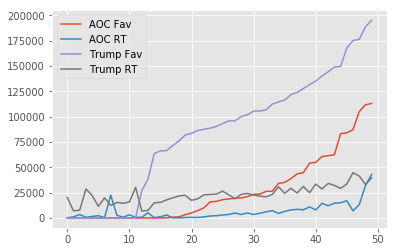

In [32]:
combined.plot()

### Exercise


Retreive the last 50 tweets with the hashtag #datavis in the SLC area, print the text and the username.